<a href="https://colab.research.google.com/github/Daniel-R-Armstrong/Alice-s-Restaurant/blob/master/d_redo_taxi_drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[16,10]
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb

%matplotlib inline
plt.rcParams['axes.unicode_minus']= False


In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!pip install kaggle 


    100% |████████████████████████████████| 51kB 1.9MB/s 
    100% |████████████████████████████████| 51kB 5.5MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/56/65/d9/88f616157b8a1848ce77c35a398b09d0566ba1fd9cc34eaa03
Successfully built kaggle


In [0]:
!kaggle competitions list #gives a list of active competitions

In [0]:
!kaggle competitions list -s taxi

ref                                        deadline             category       reward  teamCount  userHasEntered  
-----------------------------------------  -------------------  ----------  ---------  ---------  --------------  
nyc-taxi-trip-duration                     2017-09-15 23:59:00  Playground    $30,000       1257            True  
pkdd-15-predict-taxi-service-trajectory-i  2015-07-01 23:59:00  Research         $250        381           False  
pkdd-15-taxi-trip-time-prediction-ii       2015-07-01 23:59:00  Research         $250        345           False  
new-york-city-taxi-fare-prediction         2018-09-25 23:59:00  Playground  Knowledge        460           False  
porto-seguro-safe-driver-prediction        2017-11-29 23:59:00  Featured      $25,000       5169           False  
spooky-author-identification               2017-12-15 23:59:00  Playground    $25,000       1244           False  


In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')
!ls drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > drive/created.txt

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
ls drive

Colab Notebooks/     Music/
created.txt          Photos for baby book/
Dan School/          Pictures/
drop box pictures/   rusume & jobs/
Farming/             stuff to save/
fav/                 taxes/
Getting started      Thomas movies/
Google Photos/       To read/
Heather drive/       Tri bottom project/
heather word docs/   weather-data-in-new-york-city-2016.zip
iPhone camera roll/  weather_data_nyc_centralpark_2016(1).csv
kaggle/              Worth/


In [0]:
!kaggle competitions download  -c nyc-taxi-trip-duration -p drive/kaggle 

sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
from shutil import unpack_archive
unpack_archive('drive/kaggle/test.zip')
unpack_archive('drive/kaggle/train.zip')
#what I found it that if you use this it will put them in the colab file system to use as a csv file so you can call them by name(test.csv, train.csv, ect)

In [0]:
ls 

datalab/  drive/  test.csv  train.csv


In [0]:
#   train = pd.read_csv('drive/toxic_competition/train.csv', encoding = 'utf8') sub.to_csv('drive/toxic_competition/submission.csv', index=False)

In [0]:
df_train = pd.read_csv('train.csv', header=0, sep=',', quotechar='"')
df_test = pd.read_csv('test.csv', header=0, sep=',', quotechar='"')

In [0]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [0]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #sets pandas float to three digets, I think it makes it easier to look at more pandas settings at (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.set_option.html
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [0]:
df_train.describe() 

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


I personally love to look at the pandas summary. It gives me a chance to think about the categories and think more about what they mean, and what features I feel would be helpful. 

As a former boy scout/Eagle scout I am sad to say that I don’t remember anything about latitude and longitude. Just like most types of domain knowledge it would be helpful to know what you are looking at and what you are looking for, but I don’t think it is a requirement, you just need to know what to look for in your data. 

The pickup_longitude is a great example a minimum of -121.93 and a maximum of -61.33, that doesn’t mean anything but when you add the 25 ,50, and 75 percentiles at all around 73.9, you know there is a problem, most likely it is a sign that we need to do some data cleaning. The same is true with the trip_duration a tripe with 1(min) a trip with 3526282 (max)


In [0]:
df_train.info() #look for null values and anything else that sticks out that could be an issues/feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Since *pickup_datetim*e and *dropoff_datetime* are labled as object we are going to want to change this to a date time object so we can create more features and help with the training. 



In [0]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.date #come back to this it doesnt seem like it is changing to .date still object, tried df_train['pickup_date'] = df_train['pickup_datetime'].dt.date, the result was the same. 
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.date #""  
          #.loc is a way to select data by label or by a conditional statment (.loc)     https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/#loc-selection
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)#this is not present in test set, so we are only doing it on training set

In [0]:
df_train.info()#see how it has been changed to datetime64[ns]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 12 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
pickup_date           1458644 non-null object
dtypes: datetime64[ns](2), float64(4), int64(3), object(3)
memory usage: 133.5+ MB


In [0]:
mean_trip = np.mean(df_train['trip_duration'])#mean
std_trip = np.std(df_train['trip_duration']) #standard deviation
df_train = df_train[df_train['trip_duration'] <= mean_trip + 2*std_trip] #remove trips more than 2 standard devition over mean
df_train = df_train[df_train['trip_duration'] >= mean_trip - 2*std_trip] #remove trips more than 2 standard devition below mean

the google machine states that the latitude and longitude of New York city are:

West -74.257159 East -73.699215
North 40.915568 South 40.495992


https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/nybb_metadata.pdf?ver=18b


In [0]:
df_train = df_train[df_train['pickup_longitude'] <= -73.699215]
df_train = df_train[df_train['pickup_longitude'] >= -74.257159]
df_train = df_train[df_train['pickup_latitude'] <= 40.915568]
df_train = df_train[df_train['pickup_latitude'] >= 40.495992]
df_train = df_train[df_train['dropoff_longitude'] <= -73.699215]
df_train = df_train[df_train['dropoff_longitude'] >= -74.257159]
df_train = df_train[df_train['dropoff_latitude'] <= 40.915568]
df_train = df_train[df_train['dropoff_latitude'] >= 40.495992]
#these are different that other kagglers so hopefully this wont cause any issues

In [0]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1455201.000,1455201.000,1455201.000,1455201.000,1455201.000,1455201.000,1455201.000
mean,1.534,1.664,-73.974,40.751,-73.974,40.752,835.705
std,0.499,1.314,0.038,0.028,0.035,0.032,656.594
min,1.000,0.000,-74.255,40.496,-74.255,40.496,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,661.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1072.000
max,2.000,9.000,-73.704,40.914,-73.699,40.916,11411.000


In [0]:
outliers = 1458644-1455201
print(outliers)

3443


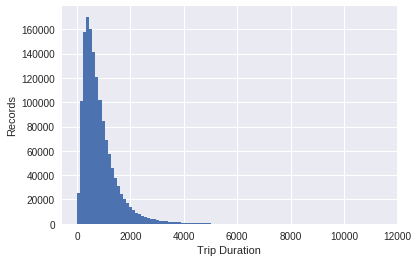

In [0]:
plt.hist(df_train['trip_duration'].values, bins=100)
plt.xlabel('Trip Duration')
plt.ylabel('Records')
plt.show()
#there still might be outliers in trip duration

<function matplotlib.pyplot.show>

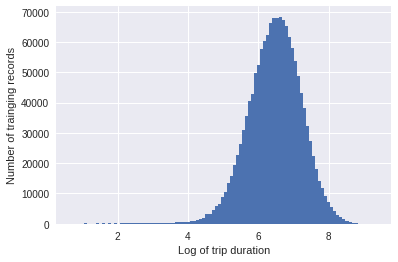

In [0]:
df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values + 1)
plt.hist(df_train['log_trip_duration'].values, bins=100)
plt.xlabel('Log of trip duration')
plt.ylabel('Number of trainging records')
plt.show


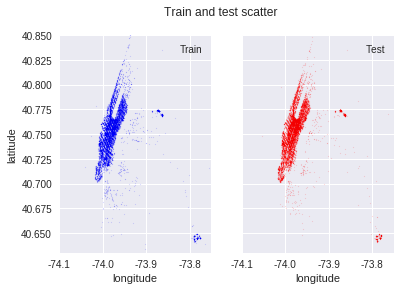

In [0]:
# creating variables to be used in plot
N=10000 #allows you to change data points in plot
graph_long_border = (-74.10,-73.75)# changes plot zoom and center
graph_lat_border = (40.63,40.85)# changes plot zoom and center

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:N], 
              df_train['pickup_latitude'].values[:N],
              color='blue', s=1, label='Train',alpha=0.1)
ax[1].scatter(df_test['pickup_longitude'].values[:N], 
              df_test['pickup_latitude'].values[:N],
              color='red', s=1, label='Test',alpha=0.1)
#optional
plt.ylim(graph_lat_border)   #sets plot y limit
plt.xlim(graph_long_border) #sets plot x limit
fig.suptitle('Train and test scatter')  # adds title in center
ax[0].legend()#loc=0,loc=1,ect. to change the legend location
ax[1].legend()
ax[0].set_ylabel('latitude') #plot 1 y axis label
ax[0].set_xlabel('longitude')#plot 1 x axis label
ax[1].set_xlabel('longitude')#plot 2 x axis label

plt.ylim(graph_lat_border)
plt.xlim(graph_long_border)
plt.show()


In [0]:

!kaggle datasets download -d mathijs/weather-data-in-new-york-city-2016 -p drive/kaggle/taxi
#this download two files, weather-data-in-new-york-city-2016.zip, weather_data_nyc_centralpark_2016(1).csv

weather-data-in-new-york-city-2016.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
ls drive/kaggle/taxi

accidents_2016.csv               test.csv
fastest_routes_test.csv          test.zip
fastest_routes_train_part_1.csv  TPOT.ipynb
fastest_routes_train_part_2.csv  train.csv
sample_submission.zip            train.zip
second_fastest_routes_test.csv   weather-data-in-new-york-city-2016.zip
second_fastest_routes_train.csv  weather_data_nyc_centralpark_2016(1).csv


In [0]:
wdf = pd.read_csv('drive/kaggle/taxi/weather_data_nyc_centralpark_2016(1).csv')

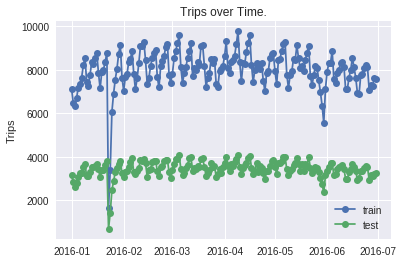

In [0]:
plt.plot(df_train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(df_test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

No handles with labels found to put in legend.


Text(0,0.5,'Time in Seconds')

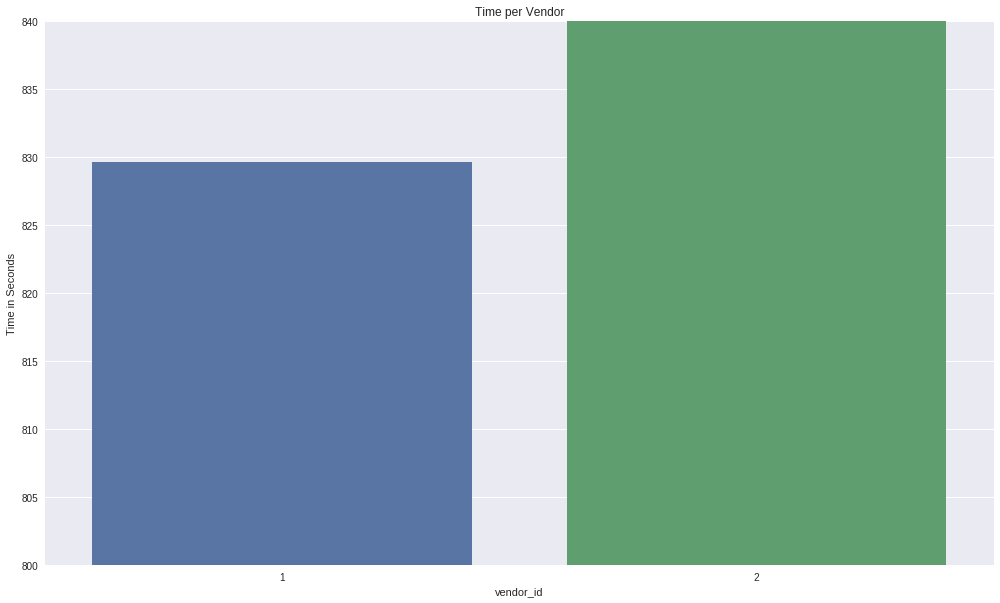

In [0]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = df_train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

No handles with labels found to put in legend.


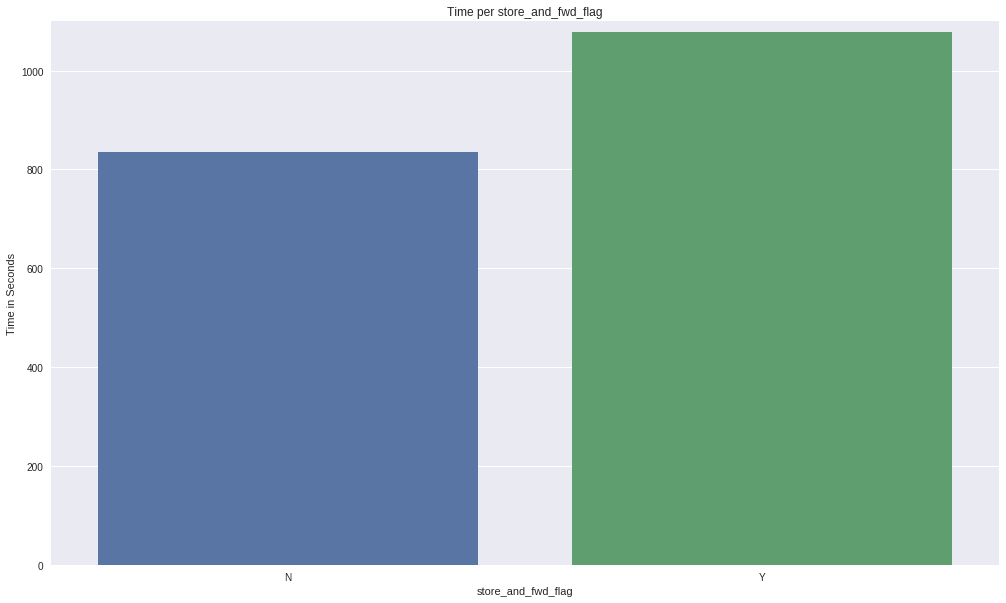

In [0]:
snwflag = df_train.groupby('store_and_fwd_flag')['trip_duration'].mean()#might want to change to bool

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(snwflag.index,snwflag.values)

No handles with labels found to put in legend.


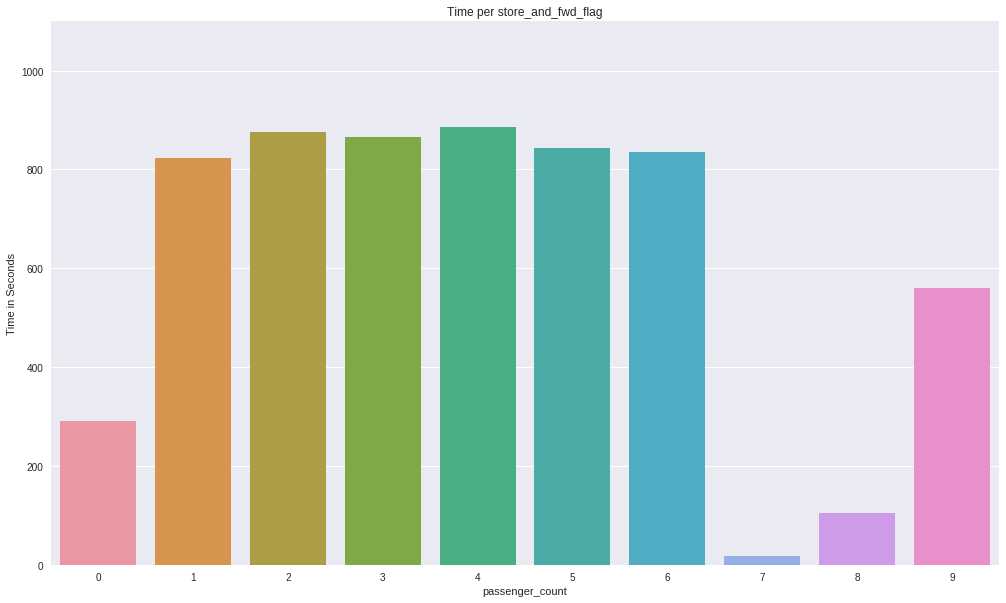

In [0]:
pc = df_train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

In [0]:
df_train.groupby('passenger_count').size()

passenger_count
0         59
1    1031272
2     209817
3      59729
4      28317
5      77826
6      48177
7          2
8          1
9          1
dtype: int64

In [0]:
df_test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

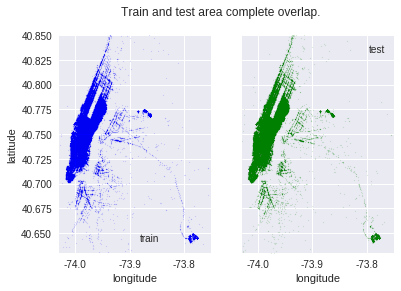

In [0]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:100000], df_train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df_test['pickup_longitude'].values[:100000], df_test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()




In [0]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

applying these functions to both the test and train data, we can calculate the haversine distance which is the great-circle distance between two points on a sphere given their longitudes and latitudes. We can then calculate the summed distance traveled in Manhattan. And finally we calculate (through some handy trigonometry) the direction (or bearing) of the distance traveled. These calculations are stored as variables in the separate data sets. The next step I decided to take is to create neighourhods, like Soho, or the Upper East Side, from the data and display this.

In [0]:
df_train.loc[:, 'distance_haversine'] = haversine_array(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)
df_test.loc[:, 'distance_haversine'] = haversine_array(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, df_test['dropoff_latitude'].values, df_test['dropoff_longitude'].values)    
    
df_train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values,df_train['dropoff_longitude'].values)
df_test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, df_test['dropoff_latitude'].values, df_test['dropoff_longitude'].values)

df_train.loc[:, 'direction'] = bearing_array(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)
df_test.loc[:, 'direction'] = bearing_array(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, df_test['dropoff_latitude'].values, df_test['dropoff_longitude'].values)

3.3.3 Lets create the "Neighborhoods"

One might think it necessary to have a map handy to do this, but not really. This will intuitively work as KMeans will cluster the data points into their own neighborhoods. This is pretty straight forward since Numpy helps create a vertically stacked array of the pickup and dropoff coordinates, and using `sklearn`'s MiniBatchKMeans module it's easy to set up the parameters to create the clusters.

There are three steps to preparing the data: create the coordinates stack, configure the KMeans clustering parameters, and create the actual clusters:

In [0]:
from sklearn.cluster import MiniBatchKMeans

coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values))
sample_ind = np.random.permutation(len(coords))[:500000]

kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
df_train.loc[:, 'pickup_cluster'] = kmeans.predict(df_train[['pickup_latitude', 'pickup_longitude']])
df_train.loc[:, 'dropoff_cluster'] = kmeans.predict(df_train[['dropoff_latitude', 'dropoff_longitude']])
df_test.loc[:, 'pickup_cluster'] = kmeans.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test.loc[:, 'dropoff_cluster'] = kmeans.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])

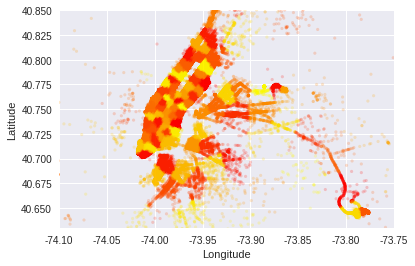

In [0]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_train.pickup_longitude.values[:500000], df_train.pickup_latitude.values[:500000], s=10, lw=0,
           c=df_train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(graph_long_border)
ax.set_ylim(graph_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [0]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [0]:
train.groupby('Month').size(),test.groupby('Month').size()

In [0]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

In [0]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

In [0]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

In [0]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

In [0]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

For this particular problem we can add OSRM ([Open Source Routing Machine](http://project-osrm.org/ "OSRM")) features. Ultimately this is a data set containing the fastest routes from specific starting points in NY.

In [0]:
fr1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

In [0]:
train.shape, test.shape

In [0]:
#creating dummy variables 
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [0]:
vendor_train.shape,vendor_test.shape

In [0]:
passenger_count_train.shape,passenger_count_test.shape

In [0]:
store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape

In [0]:
cluster_pickup_train.shape,cluster_pickup_test.shape

In [0]:
cluster_dropoff_train.shape,cluster_dropoff_test.shape

In [0]:
month_train.shape,month_test.shape

In [0]:
dom_train.shape,dom_test.shape

In [0]:
hour_train.shape,hour_test.shape

In [0]:
dow_train.shape,dow_test.shape

In [0]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

And it would seem we've finally reached the end of what is easily considered the most difficult part of data science: cleaning and wrangling the data into a usable format/structure. The last part before we actually start training the model is to drop the categorical variables (since we replaced these with our indicator variables in the previous step) and compile the final version of our test and train sets.

In [0]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

In [0]:
train.shape,test.shape

In [0]:
#add indicator values
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_test,
                          dow_train
                         ], axis=1)

In [0]:
Test_master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [0]:
Train_Master.shape,Test_master.shape

In [0]:
#info already included in other varables, so get rid of them
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_master = Test_master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [0]:
Train_Master.shape,Test_master.shape

For the sake of this tutorial we'll stick to 100 000 data points, this just makes the training process faster and a little less cumbersome to work with. Also, we'll split the training set into a 80-20 train and test set. So from this, there are two things you can do: change the ratios by which you split the original training set (`Train_Master`), e.g. use a 70-30 ratio and see what the results are. Also, you can include all the data points instead of just 100k. This should also have quite a siginficant effect on the outcome.


So the split would look something like this:

In [0]:
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

Some additional steps are required for us to use these datasets. One thing is to drop the `log_trip_duration` features (this is merely a log transform of one of the features, so it's signficance will remain the same as when it isn't transformed). Also, we can drop our original index and reset it, to make sure we can reference the rows accurately if needed.

In [0]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

One more step and it really is time to start training: We need to create the XGBoost matrices that will be used to train the model using XGBoost. Note that we use the newly created test and train sets as our model training inputs (for train and validation) and finally use the master test set to make our predictions.

In [0]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

Finally! We're ready to use XGBoost. You'll notice that this part is actually quite short. But only in code. It can take quite a while to itterate through the different parameters and different values of these parameters to better the outcome of the model. Let's see what's next.

5. XGBoost - Training the Model and Testing the Accuracy
As mentioned you can play with the different parameters of the XGBoost algorithm to tweak the model's outcome. So below is a short, but very nice, way of itterating through model parameters to tweak the model. So it's implementation is simple: just uncomment the code and run the kernel. Again, refer to the [documentation for XGBoost](http://xgboost.readthedocs.io/en/latest/python/python_intro.html "XGBoost Documentation") to understand what each parameter does and how it alters the behaviour of the training process.

Here is one for the fork's. I do recomend you trying to play with these metrics though...

In [0]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

f course, what type of tutorial would this be if I didn't give some ideas about where to twea the model? Here are some steps I suggest you follow:

Make it more than 10 iterations before stopping.
Lower the eta-value.
Increase the max depth.
Be very careful though, there is such a thing as overfitting. I.e. training your model so well on the training set that it performs quite poorly on unseen data. Here I would suggest playing with `colsample_bytree` and `subsample` to control overfitting.


Out of interest, we can investigate the importance of each feature, to understand what affects the trip duration the most significantly. Here's how XGBoost allows us to do it:

In [0]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

So from top to bottom we see which features have the greatest affect on trip duration. It would make logical sense that distance has the greatest affect. The further you travel, the longer it'll take. The rest of the features follow a similar logic in why it's ranked the way it is.


The final step before submission is to make our predictions using the trained model:

In [0]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1

It's as simple as that. We've now successfully trained a model and made predictions on unseen data about how long it would take to get from A to B. Thus, the last step in getting yourself onto the leaderboard is to make a submission. Let's do that quickly:

Time for Submission

infomation from https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial

In [0]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)

In [0]:
!pip install TPOT

    100% |████████████████████████████████| 890kB 6.5MB/s 
    100% |████████████████████████████████| 942kB 9.0MB/s 
  Running setup.py bdist_wheel for TPOT ... - \ done
  Stored in directory: /content/.cache/pip/wheels/00/f3/4d/8d28f69c59669ba720eebaa4ebc8a3b28da2a61662367b38e8
  Running setup.py bdist_wheel for deap ... - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
  Running setup.py bdist_wheel for stopit ... - done
  Stored in directory: /content/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built TPOT deap stopit


In [0]:
features_names = list(df_train.columns)
y = np.log.log(df_train['trip_duration'].values+1)
x_tr, xtv, ytr, yv= train_test_split(df_train[features_names].values, y, test_size=.02, random_state=1983)

model = xgb_train('default',df_train)

AttributeError: ignored